In [1]:
# Main imports
import pandas as pd
import numpy as np
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import os, sys
import seaborn as sns
from tqdm import tqdm
from copy import deepcopy
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
nltk.download('punkt')
tqdm.pandas()

[nltk_data] Downloading package punkt to /Users/iranjan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
bglobe_data = pd.read_csv('/Users/iranjan/Projects/dd4g-bias-in-media/data/cleaned_articles_mass.csv')

In [4]:
bglobe_data.head()

,position_section,position_subsection,hl1,hl2,author,lede,body,pub_date,indexing_terms,year,actual_body_word_count,body_cleaned
0,BUSINESS,unknown,cerezyme alternative gets fda approval,unknown,Associated Press,washington - the food and drug administration ...,washington - the food and drug administration ...,2010-02-27,"{'subject': [{'score': '91', 'classCode': 'ST0...",2010,91,washington food drug administration approved n...
1,G,Living Arts,unknown,unknown,AMI ALBERNAZ,earth-friendly sale porter square eco-boutique...,shoes with moxie moxie is taking 20 percent of...,2010-04-22,"{'subject': [{'score': '90', 'classCode': 'ST0...",2010,381,shoes moxie moxie taking 20 percent sexy ' hee...
2,NEWS,Metro,unknown,unknown,unknown,"boston 96 orlando 84 celtics win series, 4-2","boston 96 orlando 84 celtics win series, 4-2",2010-05-29,"{'organization': [{'score': '84', 'className':...",2010,8,"boston 96 orlando 84 celtics win series , 4-"
3,NEWS,Metro,"leave car home for first night, city urges",unknown,unknown,the mayor of boston and the city's top brass h...,``first night is so memorable and fun; what's ...,2010-12-29,"{'subject': [{'score': '90', 'classCode': 'STX...",2010,343,first night memorable fun ; ' fun getting park...
4,NEWS,Metro,a flawed calculus,unknown,Kevin Cullen,"when it comes to amy bishop, the harvard-train...","in 1993, amy bishop and her husband, james and...",2010-02-16,"{'subject': [{'score': '90', 'classCode': 'STX...",2010,555,"1993 , amy bishop husband , james anderson , q..."


In [5]:
unique_topics = bglobe_data['position_section'].value_counts()
num_topics = len(unique_topics)

print("Number of unique topics:", num_topics)
print("Number of articles correlated to each topic:")
print(unique_topics)


Number of unique topics: 16
Number of articles correlated to each topic:
NEWS                 50745
LIVING ARTS          30543
SPORTS               29071
BUSINESS             27681
EDITORIAL OPINION    15252
REGIONAL             13367
G                     4306
MAGAZINE              3748
SUNDAY                2963
REALESTATE            1057
unknown                 95
DIVERSITY               19
TABM                    14
TAB2                     4
PROJECT                  2
ADVSUP                   1
Name: position_section, dtype: int64


In [6]:
g_df = bglobe_data[bglobe_data['position_section'] == 'G']
g_df['position_section'] = g_df.apply(lambda row: row['position_subsection'] if row['position_section'] == 'G' else row['position_section'], axis=1)
unique_topics_g = g_df['position_section'].value_counts()
num_topics_g = len(unique_topics_g)

print("Number of unique topics:", num_topics_g)
print("Number of articles correlated to each topic:")
print(unique_topics_g)


Number of unique topics: 5
Number of articles correlated to each topic:
Living Arts    3936
Food            359
G                 9
Metro             1
unknown           1
Name: position_section, dtype: int64


/var/folders/gh/q7237klx1c30tt_49g13wllc0000gn/T/ipykernel_27184/1240734670.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_df['position_section'] = g_df.apply(lambda row: row['position_subsection'] if row['position_section'] == 'G' else row['position_section'], axis=1)


In [7]:
gg_df = g_df[g_df['position_section'] == 'G']
gg_df

,position_section,position_subsection,hl1,hl2,author,lede,body,pub_date,indexing_terms,year,actual_body_word_count,body_cleaned
333,G,G,cells unlike any others,unknown,IRENE MUNIZ,"like any other high school student, rebecca sk...",after lacks was diagnosed with an aggressive c...,2010-02-09,"{'subject': [{'score': '90', 'classCode': 'STX...",2010,508,lacks diagnosed aggressive cervical cancer 195...
2404,G,G,"boston ballet's `la bayadère' breathtaking, he...",unknown,unknown,the late 19th-century ballet ``la bayadère'' s...,the story is a simple and - predictably - trag...,2010-11-06,"{'subject': [{'score': '90', 'classCode': 'ST0...",2010,460,"story simple predictably tragic one : nikiya ,..."
9570,G,G,`aftermath' brings iraq war close to home,unknown,unknown,"``we have left everything behind,'' an iraqi r...",``aftermath'' was created by the husband-and-w...,2010-10-29,"{'legal': [{'className': 'Immigration Law', 'c...",2010,712,aftermath ' created husband- and- wife team er...
15390,G,G,james lets zoo go untamed,`zookeeper' is a confused mashup lacking age-a...,unknown,``zookeeper'' is multiple movies for the price...,dawson walks through ``zookeeper'' with charm ...,2011-07-08,"{'subject': [{'score': '89', 'classCode': 'ST0...",2011,425,dawson walks zookeeper ' charm aplomb . presum...
17392,G,G,novel touches in ballet's latest `romeo and ju...,unknown,unknown,"with its passion, its poetry, its politics, an...","over the past 30 years, boston ballet has done...",2011-11-05,"{'subject': [{'score': '90', 'classCode': 'N71...",2011,613,"past 30 years , boston ballet done versions ro..."
18605,G,G,art's `ajax' runs afoul of its gimmicks,unknown,unknown,"cambridge - shame and humiliation, sophocles k...","it's a pity, because benson was right to belie...",2011-02-18,"{'legal': [{'className': 'Evidence', 'classCod...",2011,603,"' pity , benson right believe ajax , originall..."
20853,G,G,"monster jams kept coming, thanks to one star a...",unknown,unknown,"the acts may change each year, but jam'n 94.5'...",the only thing different in this year's editio...,2011-12-02,{'legal': [{'className': 'Computer & Internet ...,2011,381,"thing different year ' edition , ironic twist ..."
22181,G,G,"ballet productions run hot, cold",contemporary offerings include 2 world premiers,unknown,boston ballet's production of jirí kylián's ``...,the dancing occurs in duets more often than no...,2011-04-30,"{'subject': [{'score': '90', 'classCode': 'ST0...",2011,425,"dancing occurs duets often , nine dancers rico..."
23680,G,G,universal themes bring `before i leave you' to...,unknown,unknown,"``before i leave you,'' a flawed but touching ...",now receiving its world premiere in a huntingt...,2011-10-28,"{'subject': [{'score': '89', 'classCode': 'ST0...",2011,613,receiving world premiere huntington theatre co...


In [8]:
news_df = bglobe_data[bglobe_data['position_section'] == 'NEWS']
unique_topics_news = news_df['position_subsection'].value_counts()
num_topics_news = len(unique_topics_news)

print("Number of unique topics:", num_topics_news)
print("Number of articles correlated to each topic:")
print(unique_topics_news)



Number of unique topics: 3
Number of articles correlated to each topic:
Metro            49109
unknown           1620
HealthScience       16
Name: position_subsection, dtype: int64


In [9]:
news_df[news_df['position_subsection'] == 'unknown'].head(100)

,position_section,position_subsection,hl1,hl2,author,lede,body,pub_date,indexing_terms,year,actual_body_word_count,body_cleaned
107,NEWS,unknown,local sneaker firms are making it in indonesia,eager to expand new footwear foothold as costs...,unknown,"tangerang, indonesia - that ubiquitous ``made ...",at the new factory here in tangerang - a facil...,2010-05-29,"{'legal': [{'className': 'Education Law', 'cla...",2010,760,new factory tangerang facility size football f...
203,NEWS,unknown,they're just not the retiring type,the fastest growing segment of the workforce i...,unknown,they have been on the job since the nixon admi...,"``it's what keeps me going, you know?'' said t...",2010-05-22,{'legal': [{'className': 'Labor & Employment L...,2010,937,"' keeps going , know ? said tony piccuito , 91..."
238,NEWS,unknown,unknown,unknown,unknown,the chris matthews show. topics: will african-...,fox newssunday. topics: midterm elections; the...,2010-07-25,"{'legal': [{'className': 'Civil Rights Law', '...",2010,333,fox newssunday . topics : midterm elections ; ...
593,NEWS,unknown,many must fend for themselves,state of emergency won't solve most homeowners...,unknown,"winchester - on a clear sunny day, paul welliv...",but welliver and others mucking out damaged ba...,2010-03-17,"{'legal': [{'className': 'Insurance Law', 'cla...",2010,871,welliver others mucking damaged basements most...
613,NEWS,unknown,sox spend up a storm,unprecedented deals put boston in the yankees'...,unknown,"take that, evil empire. seven years after the ...",title talk swirls for sox. c1. the professiona...,2010-12-10,"{'subject': [{'score': '89', 'classCode': 'STX...",2010,1122,title talk swirls sox . c1 . professional spor...
...,...,...,...,...,...,...,...,...,...,...,...,...
11199,NEWS,unknown,merger could lift airfares in boston,southwest-airtran deal means less competition,unknown,southwest airlinessaid yesterday that it plans...,the transaction still needs approval from the ...,2010-09-28,{'legal': [{'className': 'Business & Corporate...,2010,718,transaction still needs approval us department...
11272,NEWS,unknown,state wants postal land,a push to save rail expansion financing is unc...,unknown,massachusetts will try to buy the entire 16-ac...,"``this is a 100-year transportation decision,'...",2010-01-08,"{'legal': [{'className': 'Governments', 'class...",2010,712,"100- year transportation decision , said peter..."
11296,NEWS,unknown,"redirected toward bright future, but shadowed ...",college-bound man faces sentence for '08 crime,unknown,he was a face of redemption in the boston scho...,"the conviction came, coincidentally, the same ...",2010-07-08,{'legal': [{'className': 'Criminal Law & Proce...,2010,1177,"conviction came , coincidentally , week boston..."
11346,NEWS,unknown,state's cuts leave greenway wanting,funding down 25 percent for unfinished park,unknown,the state is cutting funds for the rose fitzge...,the overall budget for the 15-acre park system...,2010-07-21,"{'legal': [{'className': 'Torts', 'classCode':...",2010,872,overall budget 15- acre park system dropped $ ...


In [10]:
indexes = bglobe_data['indexing_terms']
bglobe_data.head()

,position_section,position_subsection,hl1,hl2,author,lede,body,pub_date,indexing_terms,year,actual_body_word_count,body_cleaned
0,BUSINESS,unknown,cerezyme alternative gets fda approval,unknown,Associated Press,washington - the food and drug administration ...,washington - the food and drug administration ...,2010-02-27,"{'subject': [{'score': '91', 'classCode': 'ST0...",2010,91,washington food drug administration approved n...
1,G,Living Arts,unknown,unknown,AMI ALBERNAZ,earth-friendly sale porter square eco-boutique...,shoes with moxie moxie is taking 20 percent of...,2010-04-22,"{'subject': [{'score': '90', 'classCode': 'ST0...",2010,381,shoes moxie moxie taking 20 percent sexy ' hee...
2,NEWS,Metro,unknown,unknown,unknown,"boston 96 orlando 84 celtics win series, 4-2","boston 96 orlando 84 celtics win series, 4-2",2010-05-29,"{'organization': [{'score': '84', 'className':...",2010,8,"boston 96 orlando 84 celtics win series , 4-"
3,NEWS,Metro,"leave car home for first night, city urges",unknown,unknown,the mayor of boston and the city's top brass h...,``first night is so memorable and fun; what's ...,2010-12-29,"{'subject': [{'score': '90', 'classCode': 'STX...",2010,343,first night memorable fun ; ' fun getting park...
4,NEWS,Metro,a flawed calculus,unknown,Kevin Cullen,"when it comes to amy bishop, the harvard-train...","in 1993, amy bishop and her husband, james and...",2010-02-16,"{'subject': [{'score': '90', 'classCode': 'STX...",2010,555,"1993 , amy bishop husband , james anderson , q..."


In [11]:
bglobe_data['keywords'] = 'unknown'

In [12]:
import json

for index in range(len(indexes)):
    try:
        keywords = ""
        x = indexes[index].replace("'", "\"")
        res = json.loads(x)
        first_key = list(res.keys())[0]
        subjects = res[first_key]
        for subject in subjects:
            keyword = subject['className']
            keywords += keyword + " "
        bglobe_data.at[index, 'keywords'] = keywords
    except:
        print(index)


1
27
43
52
54
115
118
124
137
142
143
163
171
174
192
209
210
212
243
256
260
265
279
299
302
303
332
333
365
378
411
416
419
452
454
526
544
553
555
566
580
582
608
615
658
659
663
727
780
812
816
820
851
868
890
901
907
911
928
960
966
969
1025
1040
1052
1077
1098
1117
1160
1165
1185
1197
1201
1231
1248
1274
1281
1284
1295
1327
1329
1337
1364
1379
1386
1399
1410
1440
1448
1456
1473
1475
1482
1494
1507
1537
1550
1578
1579
1594
1595
1603
1612
1618
1622
1623
1683
1711
1714
1738
1743
1744
1755
1817
1854
1855
1856
1864
1881
1900
1912
1916
1917
1921
1973
1995
2011
2012
2016
2044
2090
2098
2100
2109
2128
2134
2149
2165
2173
2175
2191
2193
2198
2200
2201
2207
2232
2240
2250
2296
2318
2326
2357
2367
2378
2380
2393
2412
2415
2459
2471
2496
2499
2517
2518
2526
2529
2538
2613
2633
2636
2637
2638
2642
2660
2677
2678
2682
2684
2694
2729
2765
2771
2799
2801
2808
2838
2845
2873
2882
2896
2919
2929
2960
2965
2990
2993
2996
3003
3036
3037
3102
3136
3163
3206
3247
3278
3280
3292
3310
3323
3330
3334
334

In [13]:
bglobe_data.head()

,position_section,position_subsection,hl1,hl2,author,lede,body,pub_date,indexing_terms,year,actual_body_word_count,body_cleaned,keywords
0,BUSINESS,unknown,cerezyme alternative gets fda approval,unknown,Associated Press,washington - the food and drug administration ...,washington - the food and drug administration ...,2010-02-27,"{'subject': [{'score': '91', 'classCode': 'ST0...",2010,91,washington food drug administration approved n...,DRUG & MEDICAL DEVICES APPROVAL GENETIC DISEAS...
1,G,Living Arts,unknown,unknown,AMI ALBERNAZ,earth-friendly sale porter square eco-boutique...,shoes with moxie moxie is taking 20 percent of...,2010-04-22,"{'subject': [{'score': '90', 'classCode': 'ST0...",2010,381,shoes moxie moxie taking 20 percent sexy ' hee...,unknown
2,NEWS,Metro,unknown,unknown,unknown,"boston 96 orlando 84 celtics win series, 4-2","boston 96 orlando 84 celtics win series, 4-2",2010-05-29,"{'organization': [{'score': '84', 'className':...",2010,8,"boston 96 orlando 84 celtics win series , 4-",BOSTON CELTICS
3,NEWS,Metro,"leave car home for first night, city urges",unknown,unknown,the mayor of boston and the city's top brass h...,``first night is so memorable and fun; what's ...,2010-12-29,"{'subject': [{'score': '90', 'classCode': 'STX...",2010,343,first night memorable fun ; ' fun getting park...,PUBLIC TRANSPORTATION CHOREOGRAPHY ARTISTS & P...
4,NEWS,Metro,a flawed calculus,unknown,Kevin Cullen,"when it comes to amy bishop, the harvard-train...","in 1993, amy bishop and her husband, james and...",2010-02-16,"{'subject': [{'score': '90', 'classCode': 'STX...",2010,555,"1993 , amy bishop husband , james anderson , q...",MURDER SHOOTINGS GUNSHOT WOUNDS TERRORISM INVE...


In [14]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/iranjan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [56]:
def get_sentiment_score(text):
    if pd.isna(text):
        return 0
    else:
        pols = sia.polarity_scores(text)
        return pols['compound']



In [57]:
bglobe_data['keyword_sentiment'] = 'unknown'
for index in range(len(bglobe_data)):
    keyword = bglobe_data.at[index, 'keywords']
    sentiment = get_sentiment_score(keyword)
    bglobe_data.at[index, 'keyword_sentiment'] = sentiment

In [58]:
bglobe_data.head()

,position_section,position_subsection,hl1,hl2,author,lede,body,pub_date,indexing_terms,year,actual_body_word_count,body_cleaned,keywords,keyword_sentiment,body_sentiment
0,BUSINESS,unknown,cerezyme alternative gets fda approval,unknown,Associated Press,washington - the food and drug administration ...,washington - the food and drug administration ...,2010-02-27,"{'subject': [{'score': '91', 'classCode': 'ST0...",2010,91,washington food drug administration approved n...,DRUG & MEDICAL DEVICES APPROVAL GENETIC DISEAS...,0.4767,0.0772
1,G,Living Arts,unknown,unknown,AMI ALBERNAZ,earth-friendly sale porter square eco-boutique...,shoes with moxie moxie is taking 20 percent of...,2010-04-22,"{'subject': [{'score': '90', 'classCode': 'ST0...",2010,381,shoes moxie moxie taking 20 percent sexy ' hee...,unknown,0.0,0.9887
2,NEWS,Metro,unknown,unknown,unknown,"boston 96 orlando 84 celtics win series, 4-2","boston 96 orlando 84 celtics win series, 4-2",2010-05-29,"{'organization': [{'score': '84', 'className':...",2010,8,"boston 96 orlando 84 celtics win series , 4-",BOSTON CELTICS,0.0,0.5859
3,NEWS,Metro,"leave car home for first night, city urges",unknown,unknown,the mayor of boston and the city's top brass h...,``first night is so memorable and fun; what's ...,2010-12-29,"{'subject': [{'score': '90', 'classCode': 'STX...",2010,343,first night memorable fun ; ' fun getting park...,PUBLIC TRANSPORTATION CHOREOGRAPHY ARTISTS & P...,0.6249,0.9442
4,NEWS,Metro,a flawed calculus,unknown,Kevin Cullen,"when it comes to amy bishop, the harvard-train...","in 1993, amy bishop and her husband, james and...",2010-02-16,"{'subject': [{'score': '90', 'classCode': 'STX...",2010,555,"1993 , amy bishop husband , james anderson , q...",MURDER SHOOTINGS GUNSHOT WOUNDS TERRORISM INVE...,-0.9231,-0.9972


In [59]:
bglobe_data[bglobe_data['keyword_sentiment'] != 0]


,position_section,position_subsection,hl1,hl2,author,lede,body,pub_date,indexing_terms,year,actual_body_word_count,body_cleaned,keywords,keyword_sentiment,body_sentiment
0,BUSINESS,unknown,cerezyme alternative gets fda approval,unknown,Associated Press,washington - the food and drug administration ...,washington - the food and drug administration ...,2010-02-27,"{'subject': [{'score': '91', 'classCode': 'ST0...",2010,91,washington food drug administration approved n...,DRUG & MEDICAL DEVICES APPROVAL GENETIC DISEAS...,0.4767,0.0772
3,NEWS,Metro,"leave car home for first night, city urges",unknown,unknown,the mayor of boston and the city's top brass h...,``first night is so memorable and fun; what's ...,2010-12-29,"{'subject': [{'score': '90', 'classCode': 'STX...",2010,343,first night memorable fun ; ' fun getting park...,PUBLIC TRANSPORTATION CHOREOGRAPHY ARTISTS & P...,0.6249,0.9442
4,NEWS,Metro,a flawed calculus,unknown,Kevin Cullen,"when it comes to amy bishop, the harvard-train...","in 1993, amy bishop and her husband, james and...",2010-02-16,"{'subject': [{'score': '90', 'classCode': 'STX...",2010,555,"1993 , amy bishop husband , james anderson , q...",MURDER SHOOTINGS GUNSHOT WOUNDS TERRORISM INVE...,-0.9231,-0.9972
5,NEWS,Metro,"advantage, kids","with tennis, hub police get youths off city's ...",unknown,"in tennis, how you play can matter as much as ...",``all these kids are at risk of being involved...,2010-07-20,"{'subject': [{'score': '90', 'classCode': 'STX...",2010,604,"kids risk involved gang- related activity , sa...",CHILDREN TENNIS SPORTS LAW ENFORCEMENT POLICE ...,-0.8979,0.9925
6,EDITORIAL OPINION,Opinion,davis right to ask for da probe of police in r...,unknown,unknown,boston police commissioner edward davis struck...,cellphone video taken by a student at roxbury ...,2010-10-30,"{'subject': [{'score': '92', 'classCode': 'STX...",2010,327,cellphone video taken student roxbury communit...,EDITORIALS & OPINIONS INVESTIGATIONS POLICE FO...,-0.9081,-0.9757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178840,LIVING ARTS,unknown,dream comes true,'supernatural' stars run for charity and finis...,unknown,even with numerouscelebritiesrunning the 2019 ...,"body genevieve, who was running her first mara...",2019-04-16,"{'subject': [{'score': '90', 'classCode': 'STX...",2019,236,"body genevieve , running first marathon finish...",MARATHONS CHARITIES RUNNING SPORTS FANS NONPRO...,0.6486,0.9969
178848,NEWS,Metro,weld announces primary challenge against trump,unknown,unknown,"william f. weld, the former republican governo...","body ""it is time to return to the principles o...",2019-04-16,"{'subject': [{'score': '90', 'classCode': 'ST0...",2019,406,body time return principles lincoln : equality...,US REPUBLICAN PARTY US PRESIDENTIAL CANDIDATES...,0.8176,0.9801
178855,BUSINESS,unknown,union faces a shifting food sector,grocers struggle to fend off rivals,unknown,"brian brusseau (left), member of the roofers u...",body it might also be a last stand for unioniz...,2019-04-16,"{'subject': [{'score': '90', 'classCode': 'N81...",2019,959,body might also last stand unionized grocery w...,LABOR UNIONS INDUSTRY CONSOLIDATION LEGISLATIV...,-0.3612,0.9746
178859,NEWS,Metro,providence man gets five years for his role in...,unknown,unknown,■ drug sentence a providence man received a fi...,body ■ motorcycle crash state police say four ...,2019-04-16,{'legal': [{'className': 'Criminal Law & Proce...,2019,391,body motorcycle crash state police say four pe...,Criminal Law & Procedure,-0.5267,-0.9936


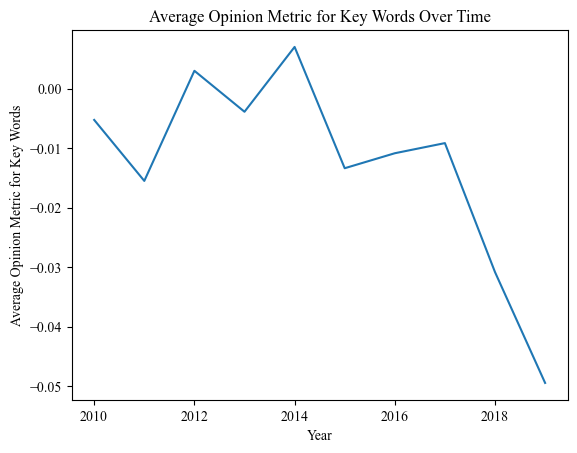

In [70]:
avg_sentiment_by_year = bglobe_data.groupby('year')['keyword_sentiment'].mean()
plt.rcParams['font.family'] = 'Times New Roman'

avg_sentiment_by_year.plot()
plt.xlabel('Year')
plt.ylabel('Average Opinion Metric for Key Words')
plt.title('Average Opinion Metric for Key Words Over Time')
plt.show()


In [25]:
bglobe_data

,position_section,position_subsection,hl1,hl2,author,lede,body,pub_date,indexing_terms,year,actual_body_word_count,body_cleaned,keywords,keyword_sentiment
0,BUSINESS,unknown,cerezyme alternative gets fda approval,unknown,Associated Press,washington - the food and drug administration ...,washington - the food and drug administration ...,2010-02-27,"{'subject': [{'score': '91', 'classCode': 'ST0...",2010,91,washington food drug administration approved n...,DRUG & MEDICAL DEVICES APPROVAL GENETIC DISEAS...,0.4767
1,G,Living Arts,unknown,unknown,AMI ALBERNAZ,earth-friendly sale porter square eco-boutique...,shoes with moxie moxie is taking 20 percent of...,2010-04-22,"{'subject': [{'score': '90', 'classCode': 'ST0...",2010,381,shoes moxie moxie taking 20 percent sexy ' hee...,unknown,0.0
2,NEWS,Metro,unknown,unknown,unknown,"boston 96 orlando 84 celtics win series, 4-2","boston 96 orlando 84 celtics win series, 4-2",2010-05-29,"{'organization': [{'score': '84', 'className':...",2010,8,"boston 96 orlando 84 celtics win series , 4-",BOSTON CELTICS,0.0
3,NEWS,Metro,"leave car home for first night, city urges",unknown,unknown,the mayor of boston and the city's top brass h...,``first night is so memorable and fun; what's ...,2010-12-29,"{'subject': [{'score': '90', 'classCode': 'STX...",2010,343,first night memorable fun ; ' fun getting park...,PUBLIC TRANSPORTATION CHOREOGRAPHY ARTISTS & P...,0.6249
4,NEWS,Metro,a flawed calculus,unknown,Kevin Cullen,"when it comes to amy bishop, the harvard-train...","in 1993, amy bishop and her husband, james and...",2010-02-16,"{'subject': [{'score': '90', 'classCode': 'STX...",2010,555,"1993 , amy bishop husband , james anderson , q...",MURDER SHOOTINGS GUNSHOT WOUNDS TERRORISM INVE...,-0.9231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178863,NEWS,Metro,illuminating colonial history,unknown,unknown,lantern bearers (above) walked down the aisles...,body,2019-04-16,"{'subject': [{'score': '86', 'classCode': 'ST0...",2019,1,body,HISTORY THIS DAY IN HISTORY ANNIVERSARIES,0.0
178864,SPORTS,unknown,sellers had a struggle to the finish,unknown,unknown,a year after her surprise second-place finish ...,"body sellers, 27, wearing bib number f23, plac...",2019-04-16,"{'subject': [{'score': '76', 'classCode': 'ST0...",2019,197,"body sellers , 27 , wearing bib number f23 , p...",SPORTS & RECREATION EVENTS SUMMER OLYMPICS MAR...,0.0
178865,LIVING ARTS,unknown,simon writing memoir about jacqueline kennedy ...,unknown,unknown,jacqueline kennedy onassis (left) in new york ...,"body carly simon is writing an ""intimate, vuln...",2019-04-16,"{'subject': [{'score': '90', 'classCode': 'ST0...",2019,105,"body carly simon writing intimate , vulnerable...",unknown,0.0
178866,SPORTS,unknown,on the air,unknown,unknown,on the air pro basketball 7 p.m. boston at mia...,body men's college basketball 7 p.m. cincinnat...,2019-01-10,"{'subject': [{'score': '90', 'classCode': 'STX...",2019,120,body men ' college basketball 7 p. m. cincinna...,PROFESSIONAL SPORTS BASKETBALL COLLEGE & UNIVE...,0.0


In [61]:
bglobe_data['body_sentiment'] = 'unknown'
for index in range(len(bglobe_data)):
    body = bglobe_data.at[index, 'body_cleaned']
    body_sentiment = get_sentiment_score(body)
    bglobe_data.at[index, 'body_sentiment'] = body_sentiment

In [27]:
bglobe_data.head()

,position_section,position_subsection,hl1,hl2,author,lede,body,pub_date,indexing_terms,year,actual_body_word_count,body_cleaned,keywords,keyword_sentiment,body_sentiment
0,BUSINESS,unknown,cerezyme alternative gets fda approval,unknown,Associated Press,washington - the food and drug administration ...,washington - the food and drug administration ...,2010-02-27,"{'subject': [{'score': '91', 'classCode': 'ST0...",2010,91,washington food drug administration approved n...,DRUG & MEDICAL DEVICES APPROVAL GENETIC DISEAS...,0.4767,0.0772
1,G,Living Arts,unknown,unknown,AMI ALBERNAZ,earth-friendly sale porter square eco-boutique...,shoes with moxie moxie is taking 20 percent of...,2010-04-22,"{'subject': [{'score': '90', 'classCode': 'ST0...",2010,381,shoes moxie moxie taking 20 percent sexy ' hee...,unknown,0.0,0.9887
2,NEWS,Metro,unknown,unknown,unknown,"boston 96 orlando 84 celtics win series, 4-2","boston 96 orlando 84 celtics win series, 4-2",2010-05-29,"{'organization': [{'score': '84', 'className':...",2010,8,"boston 96 orlando 84 celtics win series , 4-",BOSTON CELTICS,0.0,0.5859
3,NEWS,Metro,"leave car home for first night, city urges",unknown,unknown,the mayor of boston and the city's top brass h...,``first night is so memorable and fun; what's ...,2010-12-29,"{'subject': [{'score': '90', 'classCode': 'STX...",2010,343,first night memorable fun ; ' fun getting park...,PUBLIC TRANSPORTATION CHOREOGRAPHY ARTISTS & P...,0.6249,0.9442
4,NEWS,Metro,a flawed calculus,unknown,Kevin Cullen,"when it comes to amy bishop, the harvard-train...","in 1993, amy bishop and her husband, james and...",2010-02-16,"{'subject': [{'score': '90', 'classCode': 'STX...",2010,555,"1993 , amy bishop husband , james anderson , q...",MURDER SHOOTINGS GUNSHOT WOUNDS TERRORISM INVE...,-0.9231,-0.9972


In [37]:
sentiment_data = bglobe_data.drop(bglobe_data[bglobe_data['keyword_sentiment'] == 'unknown'].index)
sentiment_data = sentiment_data.drop(sentiment_data[sentiment_data['body_sentiment'] == 'unknown'].index)

sentiment_data['keyword_sentiment'] = sentiment_data['keyword_sentiment'].astype(float)
sentiment_data['body_sentiment'] = sentiment_data['body_sentiment'].astype(float)
sentiment_data = sentiment_data.drop(sentiment_data[sentiment_data['keyword_sentiment'] == 0].index)

sentiment_data['keyword_sentiment'].corr(sentiment_data['body_sentiment'])


0.4641827340374894

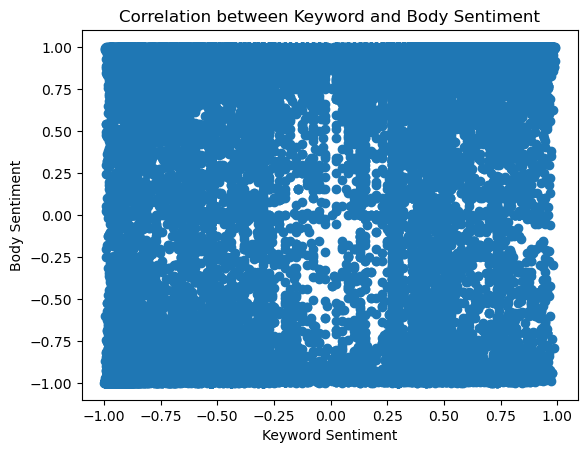

In [39]:
plt.scatter(sentiment_data['keyword_sentiment'], sentiment_data['body_sentiment'])
plt.xlabel('Keyword Sentiment')
plt.ylabel('Body Sentiment')
plt.title('Correlation between Keyword and Body Sentiment')
plt.show()


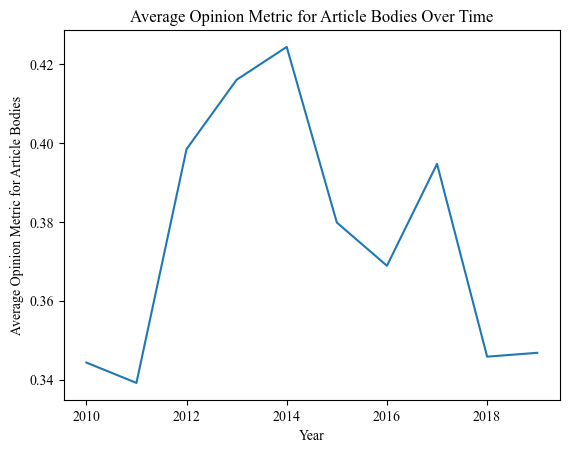

In [71]:
avg_body_sentiment_by_year = sentiment_data.groupby('year')['body_sentiment'].mean()
plt.rcParams['font.family'] = 'Times New Roman'

avg_body_sentiment_by_year.plot()
plt.xlabel('Year')
plt.ylabel('Average Opinion Metric for Article Bodies')
plt.title('Average Opinion Metric for Article Bodies Over Time')
plt.show()

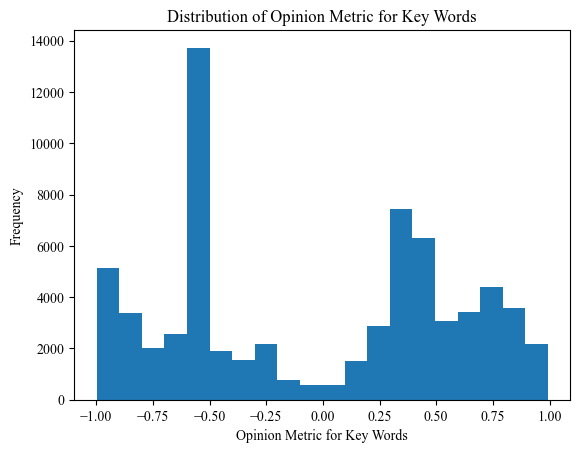

In [72]:
plt.hist(sentiment_data['keyword_sentiment'], bins=20)
plt.xlabel('Opinion Metric for Key Words')
plt.ylabel('Frequency')
plt.title('Distribution of Opinion Metric for Key Words')
plt.show()


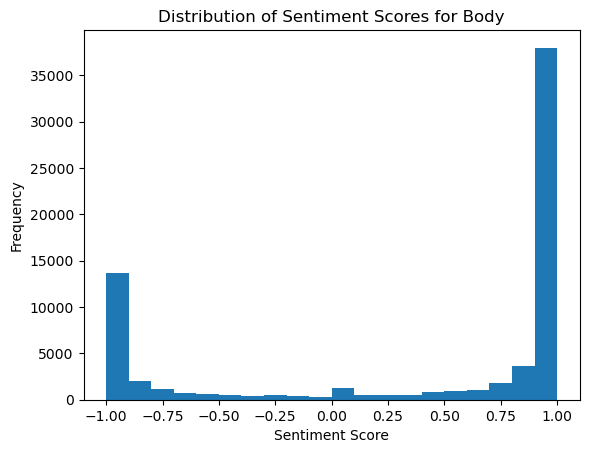

In [67]:
plt.hist(sentiment_data['body_sentiment'], bins=20)
plt.xlabel('Opinion Metric for Article Bodies')
plt.ylabel('Frequency')
plt.title('Distribution of Opinion Metric for Article Bodies')
plt.show()

69198

In [50]:
len(body_sentiment)

69198